### Load the dataset

In [1]:
from IPython.display import Audio
import librosa

import tensorflow.compat.v1 as tf
import tensorflow_io as tfio

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

import torchaudio, torch

2024-05-13 21:54:19.076064: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 21:54:20.253824: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/cx0618/.local/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/home/cx0618/.local/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/home/cx0618/.local/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl8OkStatusEv']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/home/cx0618/.local/lib/py

In [2]:
## Building the data tensor set
## Using 3400 audios for each classes
## for counting number of data in the dataset through file system;
## Reference method: image_count = len(list(DATASETPATH.glob('./*.wav')))
data_tensor_yes = []
data_tensor_no = []
data_tensor_test_yes = []
data_tensor_test_no = []
for i in range(3400):
    filename = './Dataset/yes/yes' + str(i+1) + '.wav'
    data_audio_tensor, data_rate = torchaudio.load(filename)
    data_tensor_yes.append(np.array(data_audio_tensor[0].tolist()))
for i in range(3400):
    filename = './Dataset/no/no' + str(i+1) + '.wav'
    data_audio_tensor, data_rate = torchaudio.load(filename)
    data_tensor_no.append(np.array(data_audio_tensor[0].tolist()))
## load test dataset
for i in range(490):
    filename = './test_set/yes/yes' + str(i+1) + '.wav'
    data_audio_tensor, data_rate = torchaudio.load(filename)
    data_tensor_test_yes.append(np.array(data_audio_tensor[0].tolist()))
for i in range(490):
    filename = './test_set/no/no' + str(i+1) + '.wav'
    data_audio_tensor, data_rate = torchaudio.load(filename)
    data_tensor_test_no.append(np.array(data_audio_tensor[0].tolist()))

In [3]:
## Construct the mfcc set
mfcc_set_yes = []
mfcc_set_no = []

mfcc_test_set_yes = []
mfcc_test_set_no = []

mfcc_train_labels = []
mfcc_test_labels = []
for i in data_tensor_yes:
    mfcc_audio = librosa.power_to_db(librosa.feature.melspectrogram(y=np.float32(np.array(i)),
                                                               sr=16000,
                                                               n_fft=2048,
                                                               hop_length=512,
                                                               n_mels=128), ref=np.max)
    mfcc_set_yes.append(mfcc_audio)
    mfcc_train_labels.append(1)
    
for i in data_tensor_no:
    mfcc_audio = librosa.power_to_db(librosa.feature.melspectrogram(y=np.float32(np.array(i)),
                                                               sr=16000,
                                                               n_fft=2048,
                                                               hop_length=512,
                                                               n_mels=128), ref=np.max)
    mfcc_set_no.append(mfcc_audio)
    mfcc_train_labels.append(0)


## load test mfccs
for i in data_tensor_test_yes:
    mfcc_audio = librosa.power_to_db(librosa.feature.melspectrogram(y=np.float32(np.array(i)),
                                                               sr=16000,
                                                               n_fft=2048,
                                                               hop_length=512,
                                                               n_mels=128), ref=np.max)
    mfcc_test_set_yes.append(mfcc_audio)
    mfcc_test_labels.append(1)

for i in data_tensor_test_no:
    mfcc_audio = librosa.power_to_db(librosa.feature.melspectrogram(y=np.float32(np.array(i)),
                                                               sr=16000,
                                                               n_fft=2048,
                                                               hop_length=512,
                                                               n_mels=128), ref=np.max)
    mfcc_test_set_no.append(mfcc_audio)
    mfcc_test_labels.append(0)

In [4]:
train_ds = []
test_ds = []
print(mfcc_set_yes[0].shape)

## resize
for i in mfcc_set_yes:
    resized = np.resize(i, (32,32))
    train_ds.append(resized)
for i in mfcc_set_no:
    resized = np.resize(i, (32,32))
    train_ds.append(resized)

for i in mfcc_test_set_yes:
    resized = np.resize(i, (32,32))
    test_ds.append(resized)
for i in mfcc_test_set_no:
    resized = np.resize(i, (32,32))
    test_ds.append(resized)

train_ds = np.array(train_ds)
test_ds = np.array(test_ds)

train_ds = train_ds.astype('float32')
train_ds = np.reshape(train_ds, (len(train_ds), 32, 32, 1))

test_ds = test_ds.astype('float32')
test_ds = np.reshape(test_ds, (len(test_ds), 32, 32, 1))
print(train_ds.shape)

y_train = np.array(mfcc_train_labels)
y_test = np.array(mfcc_test_labels)

(128, 32)
(6800, 32, 32, 1)


### Script

In [18]:
## test the mfccset by plotting
'''
plt.figure(figsize=(4, 3))
plt.imshow(np.swapaxes(mfcc_set[2], 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
plt.ylim(plt.ylim()[::-1])
plt.savefig('./Dataset_yes/MFCCs/0')
'''

"\nplt.figure(figsize=(4, 3))\nplt.imshow(np.swapaxes(mfcc_set[2], 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')\nplt.ylim(plt.ylim()[::-1])\nplt.savefig('./Dataset_yes/MFCCs/0')\n"

In [245]:
'''
## Output the imgs
## Would take a while
n, m= 0, 0
for i in mfcc_set_yes:
    plt.figure(figsize=(4, 3))
    plt.imshow(np.swapaxes(i, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
    plt.ylim(plt.ylim()[::-1])
## Adjusting the image saveing
    plt.gca().set_axis_off()
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig('./Dataset_MFCCs/yes/'+str(n), bbox_inches='tight', pad_inches=0)
    n += 1

for i in mfcc_set_no:
    plt.figure(figsize=(4, 3))
    plt.imshow(np.swapaxes(i, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
    plt.ylim(plt.ylim()[::-1])
    plt.gca().set_axis_off()
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig('./Dataset_MFCCs/no/'+str(m), bbox_inches='tight', pad_inches=0)
    m += 1

n, m= 0, 0
for i in mfcc_test_set_yes:
    plt.figure(figsize=(4, 3))
    plt.imshow(np.swapaxes(i, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
    plt.ylim(plt.ylim()[::-1])
    plt.gca().set_axis_off()
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig('./test_MFCCs/yes/'+str(n), bbox_inches='tight', pad_inches=0)
    n += 1

for i in mfcc_test_set_no:
    plt.figure(figsize=(4, 3))
    plt.imshow(np.swapaxes(i, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
    plt.ylim(plt.ylim()[::-1])
    plt.gca().set_axis_off()
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig('./test_MFCCs/no/'+str(m), bbox_inches='tight', pad_inches=0)
    m += 1
'''

"\n## Output the imgs\n## Would take a while\nn, m= 0, 0\nfor i in mfcc_set_yes:\n    plt.figure(figsize=(4, 3))\n    plt.imshow(np.swapaxes(i, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')\n    plt.ylim(plt.ylim()[::-1])\n## Adjusting the image saveing\n    plt.gca().set_axis_off()\n    plt.gca().xaxis.set_major_locator(plt.NullLocator())\n    plt.gca().yaxis.set_major_locator(plt.NullLocator())\n    plt.savefig('./Dataset_MFCCs/yes/'+str(n), bbox_inches='tight', pad_inches=0)\n    n += 1\n\nfor i in mfcc_set_no:\n    plt.figure(figsize=(4, 3))\n    plt.imshow(np.swapaxes(i, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')\n    plt.ylim(plt.ylim()[::-1])\n    plt.gca().set_axis_off()\n    plt.gca().xaxis.set_major_locator(plt.NullLocator())\n    plt.gca().yaxis.set_major_locator(plt.NullLocator())\n    plt.savefig('./Dataset_MFCCs/no/'+str(m), bbox_inches='tight', pad_inches=0)\n    m += 1\n\nn, m= 0, 0\nfor i in mfcc_te

In [246]:
'''
## starting to load the training dataset
## reference: https://www.tensorflow.org/tutorials/load_data/images
import pathlib
BATCH_SIZE = 32
data_dir = pathlib.Path('./Dataset_MFCCs/')

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(231, 310),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(231, 310),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './test_MFCCs',
    shuffle=True,
    image_size=(231, 310),
    batch_size=BATCH_SIZE
)

## Define classes
class_names = train_ds.class_names
print(class_names)
test_class_names = test_ds.class_names
print(test_class_names)
'''

"\n## starting to load the training dataset\n## reference: https://www.tensorflow.org/tutorials/load_data/images\nimport pathlib\nBATCH_SIZE = 32\ndata_dir = pathlib.Path('./Dataset_MFCCs/')\n\ntrain_ds = tf.keras.preprocessing.image_dataset_from_directory(\n    data_dir,\n    validation_split=0.2,\n    subset='training',\n    seed=123,\n    image_size=(231, 310),\n    batch_size=BATCH_SIZE\n)\n\nval_ds = tf.keras.preprocessing.image_dataset_from_directory(\n    data_dir,\n    validation_split=0.2,\n    subset='validation',\n    seed=123,\n    image_size=(231, 310),\n    batch_size=BATCH_SIZE\n)\n\ntest_ds = tf.keras.preprocessing.image_dataset_from_directory(\n    './test_MFCCs',\n    shuffle=True,\n    image_size=(231, 310),\n    batch_size=BATCH_SIZE\n)\n\n## Define classes\nclass_names = train_ds.class_names\nprint(class_names)\ntest_class_names = test_ds.class_names\nprint(test_class_names)\n"

In [202]:
## Configuring the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Building the model

In [5]:
num_classes = 2

model = tf.keras.Sequential([
##    tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)), ## convolution layer with 32 3*3 kernel filters
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
##    tf.keras.layers.BatchNormalization(),
##    tf.keras.layers.Dropout(0.25),
##    tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
##    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.50),
    tf.keras.layers.Flatten(),
##    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

## Complie the model
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()

2024-05-13 21:55:16.719297: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-13 21:55:16.719791: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
'''
class TestCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs):
        x = self.test_data
        loss, acc = self.model.evaluate(x, verbose=0)
        logs['test_accuracy'] = acc
result_dic = {"epochs": []}

json_logging_callback = tf.keras.callbacks.LambdaCallback(
                on_epoch_begin=lambda epoch, logs: ['0.0001'],
                on_epoch_end=lambda epoch, logs:
                result_dic["epochs"].append({
                    'epoch': epoch + 1, 
                    'acc': str(logs['accuracy']), 
                    'val_acc': str(logs['val_accuracy']),
                    'test_acc': str(logs['test_accuracy'])
                }))
'''

'\nclass TestCallback(tf.keras.callbacks.Callback):\n    def __init__(self, test_data):\n        self.test_data = test_data\n\n    def on_epoch_end(self, epoch, logs):\n        x = self.test_data\n        loss, acc = self.model.evaluate(x, verbose=0)\n        logs[\'test_accuracy\'] = acc\nresult_dic = {"epochs": []}\n\njson_logging_callback = tf.keras.callbacks.LambdaCallback(\n                on_epoch_begin=lambda epoch, logs: [\'0.0001\'],\n                on_epoch_end=lambda epoch, logs:\n                result_dic["epochs"].append({\n                    \'epoch\': epoch + 1, \n                    \'acc\': str(logs[\'accuracy\']), \n                    \'val_acc\': str(logs[\'val_accuracy\']),\n                    \'test_acc\': str(logs[\'test_accuracy\'])\n                }))\n'

In [7]:
## Train the model

EPOCHS = 40
his = model.fit(
    train_ds,
    y_train,
    validation_data=(test_ds, y_test),
    epochs=EPOCHS,
)

Epoch 1/40
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5305 - loss: 1.9686 - val_accuracy: 0.7388 - val_loss: 0.5600
Epoch 2/40
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6813 - loss: 0.6045 - val_accuracy: 0.7827 - val_loss: 0.5073
Epoch 3/40
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7330 - loss: 0.5296 - val_accuracy: 0.7939 - val_loss: 0.4718
Epoch 4/40
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7659 - loss: 0.4901 - val_accuracy: 0.7980 - val_loss: 0.4487
Epoch 5/40
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7928 - loss: 0.4490 - val_accuracy: 0.8367 - val_loss: 0.4066
Epoch 6/40
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8056 - loss: 0.4220 - val_accuracy: 0.8622 - val_loss: 0.3658
Epoch 7/40
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8173 - loss: 0.3958 - val_accuracy: 0.8643 - val_loss: 0.3506
Epoch 8/40
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8365 - loss: 0.3743 - val_accuracy: 0.

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9336 - loss: 0.2215

Test score/loss: 0.20351864397525787
Test accuracy: 0.9316326379776001
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


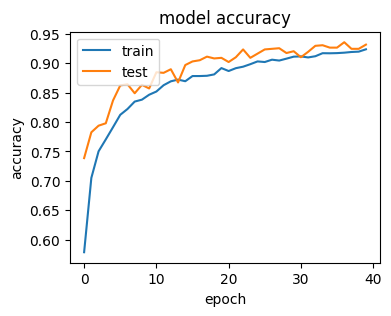

In [8]:
#Testing
score = model.evaluate(test_ds, y_test, batch_size=32)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])

# list all data in history
print(his.history.keys())

# summarize history for accuracy
#plt.plot(mo)
fig= plt.figure(figsize=(4,3))
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Evaluate

In [16]:
from ipywebrtc import CameraStream, AudioRecorder
import torchaudio, torch
camera = CameraStream(constraints=
                      {
                       'audio': True,
                       'video': False
                       })
camera
recorder = AudioRecorder(stream=camera)
recorder

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

In [17]:
recorder.save('./Recorded_audio/test.wav')
##the tensor values returned by torchaudio are much smaller than that in
##the model data strucuture. (about V(torchaudio)=lg(V(model_data))/1000)


In [18]:
custom_audio, sr_custom_audio = torchaudio.load('./Recorded_audio/test.wav')
Audio(data=np.array(custom_audio[0].tolist()), rate=sr_custom_audio)

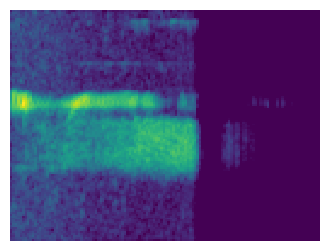

In [75]:
mfcc_audio = librosa.power_to_db(librosa.feature.melspectrogram(y=np.float32(np.array(custom_audio[0].tolist())),
                                                               sr=16000,
                                                               n_fft=2048,
                                                               hop_length=512,
                                                               n_mels=128), ref=np.max)

plt.figure(figsize=(4, 3))
plt.imshow(np.swapaxes(mfcc_audio, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
plt.ylim(plt.ylim()[::-1])
plt.gca().set_axis_off()
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig('./Recorded_audio/test_MFCC.png', bbox_inches='tight', pad_inches=0)

In [76]:
custom_test_set = []
custom_test = np.resize(mfcc_audio, (32, 32))
custom_test_set.append(custom_test)

custom_test_set = np.array(custom_test_set)
custom_test_set = np.reshape(custom_test_set, (len(custom_test_set), 32, 32, 1))
predictions = model.predict(custom_test_set)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[[-0.38474596  0.33372468]]


### Export the model

In [9]:
import pathlib
export_dir = 'models/KWS'
model.export(export_dir)

INFO:tensorflow:Assets written to: models/KWS/assets


INFO:tensorflow:Assets written to: models/KWS/assets


Saved artifact at 'models/KWS'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  134420278469104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134420278657616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134420278661312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134420278659552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134420278669584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134420278872368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134420278672928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134420278880288: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [10]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('models/KWS.tflite')
tflite_model_file.write_bytes(tflite_model)

Instructions for updating:
Use `tf.saved_model.load` instead.


Instructions for updating:
Use `tf.saved_model.load` instead.


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serve', 'serving_default'}


2024-05-13 21:56:45.343318: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serve', 'serving_default'}


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables
2024-05-13 21:56:45.451478: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


2024-05-13 21:56:45.451711: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-13 21:56:45.451859: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-05-13 21:56:45.452189: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-13 21:56:45.452374: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Instructions for upda

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serve', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serve', 'serving_default'}


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables
2024-05-13 21:56:45.709130: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-13 21:56:45.709344: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-13 21:56:45.709431: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-05-13 21:56:45.709675: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05

634256

### Post-Quantisation

In [12]:
def representative_dataset_gen(num_samples=100):
    for data in train_ds[:num_samples]:
        yield [data.reshape(1, 32, 32, 1)]
##def representative_data_gen():
##    for input_value, _ in y_test.take(100):
##        yield [input_value]
converter_op = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter_op.optimizations = [tf.lite.Optimize.DEFAULT]
converter_op.representative_dataset = representative_dataset_gen
converter_op.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_op.inference_input_type = tf.int8
converter_op.inference_output_type = tf.int8

tflite_model_file = pathlib.Path('models/KWS_op.tflite')
tflite_model_file.write_bytes(converter_op.convert())

INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serve', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serve', 'serving_default'}


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


2024-05-13 21:56:57.223563: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-13 21:56:57.223784: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-13 21:56:57.223860: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-05-13 21:56:57.224104: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-13 21:56:57.224258: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2

INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serve', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serve', 'serving_default'}


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables
2024-05-13 21:56:57.381779: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-13 21:56:57.381988: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-13 21:56:57.382067: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-05-13 21:56:57.382324: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05

164208

In [25]:
import netron
netron.start(R'./models/KWS_op.tflite')

Serving './models/KWS_op.tflite' at http://localhost:8080


('localhost', 8080)

### Create binary file

In [13]:
MODEL_TFLITE = './models/KWS_op.tflite'
MODEL_TFLITE_MICRO = 'kws_yes_no.cc'
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

In [14]:
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x9c, 0x00, 0x00, 0x00,
  0x44, 0x6b, 0x02, 0x00, 0x54, 0x6b, 0x02, 0x00, 0xd0, 0x80, 0x02, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x5c, 0x00, 0x00, 0x00, 0x2c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0xb8, 0xff, 0xff, 0xff, 0x14, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x13, 0x00, 0x00, 0x00, 0x43, 0x4f, 0x4e, 0x56, 0x45, 0x52, 0x53, 0x49,
  0x4f, 0x4e, 0x5f, 0x4d, 0x45, 0x54, 0x41, 0x44, 0x41, 0x54, 0x41, 0x00,
  0xdc, 0xff, 0xff, 0xff, 0x13, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x13, 0x00, 0x00, 0x00, 0x6d, 0x69, 0x6e, 0x5f, 0x72, 0x75, 0x6e, 0x74,
  0x69, 0x6d, 0x65, 0x5f, 0x76, 0x65, 0x72, 0x73, 0x69, 0x6f, 0x6e, 0x00,
  0x08, 0x

### Evaluation